In [ ]:
# ===========================
# Cell 0 — Config
# ===========================
# My bundles root
QAE_RUNS_ROOT = "Jacob"

# Monolith bundles root
MENTOR_RUNS_ROOT = "jacobs_examples/qae_runs"

# Datasets to evaluate (set explicitly for determinism)
DATASETS = ["mackey_glass_tau17_n200", "mackey_glass_tau30_n200"]

# Where the raw data are (for windowing & scaling)
LOG_NAME   = "jacobs_examples/aintern"
DATA_ROOT  = f"{LOG_NAME}/data"

# Fallbacks if bundle misses these
FALLBACK_SIGMA = 0.20
FALLBACK_SEED  = 99123

# Output directory for CSVs & plots
FRAMEWORK_OUT = "qae_eval_framework"

# Toggle plots
MAKE_PLOTS = True

# Optional path filter when scanning runs (keep None to include everything)
RUN_PATH_FILTER = None

In [ ]:
# ===========================
# Cell 1 — Imports & utils
# ===========================
import os, json, re, sys
from pathlib import Path
from typing import Dict, Any, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp

# repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import read_json_file, read_ts_file, create_folder_if_needed
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_add_noise

Path(FRAMEWORK_OUT).mkdir(parents=True, exist_ok=True)

def find_datasets_under(root: str) -> List[str]:
    if not Path(root).exists():
        return []
    return sorted([p.name for p in Path(root).iterdir() if p.is_dir()])

def load_dataset_series(data_id: str) -> Tuple[np.ndarray, Dict[str, float]]:
    """
    Load y, plus {scale_low, scale_high}. Robust to working directory.
    """
    base_candidates = [
        Path(DATA_ROOT),
        Path("aintern/data"),
        Path("jacobs_examples/aintern/data"),
        Path("../aintern/data"),
        Path("../jacobs_examples/aintern/data"),
        Path("../../aintern/data"),
        Path("../../jacobs_examples/aintern/data"),
    ]
    tried = []
    for base in base_candidates:
        folder = (base / data_id).resolve()
        info_p = folder / "info.json"
        y_p    = folder / "y_org.arr"
        if info_p.exists() and y_p.exists():
            info = read_json_file(str(info_p))
            y    = read_ts_file(str(y_p))
            return np.asarray(y), dict(
                scale_low=float(info["scale_low"]),
                scale_high=float(info["scale_high"]),
            )
        tried.append(str(folder))

    for root in [Path.cwd(), Path.cwd().parent]:
        for folder in root.rglob(data_id):
            if not folder.is_dir():
                continue
            info_p = folder / "info.json"
            y_p    = folder / "y_org.arr"
            if info_p.exists() and y_p.exists():
                info = read_json_file(str(info_p))
                y    = read_ts_file(str(y_p))
                return np.asarray(y), dict(
                    scale_low=float(info["scale_low"]),
                    scale_high=float(info["scale_high"]),
                )
            tried.append(str(folder))

    raise FileNotFoundError(
        f"Missing dataset files for {data_id}. Searched:\n  - " + "\n  - ".join(tried)
    )

def arch_from_tag(tag: str) -> Tuple[int,int,int]:
    m = re.match(r"(\d+)q_(\d+)l_(\d+)t", tag)
    if not m:
        raise ValueError(f"Bad arch_tag: {tag}")
    return int(m[1]), int(m[2]), int(m[3])

def windows_from_seed(y_vec, sigma, seed, wind_size, wind_step, split, scale_low, scale_high):
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=int(seed)
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_c, _, te_c = ts_wind_split(X_ts, win_clean, split)
    _, tr_n, _, te_n = ts_wind_split(X_ts, win_noisy, split)
    return np.asarray(tr_c), np.asarray(tr_n), np.asarray(te_c), np.asarray(te_n)

def flatten_avg(windows, wind_step):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

In [ ]:
# ===========================
# Cell 2 — z->values, diff method
# ===========================
def choose_diff_method(reset_mode: str, requested: str = "adjoint") -> str:
    r = (reset_mode or "").lower()
    if r == "swap" and requested == "adjoint":
        return "adjoint"
    return "best"

# Author-specific inverse mappings
def map_z_to_value_mine(z_all, scale_low, scale_high):
    z = np.clip(np.asarray(z_all), -0.999999, 0.999999)
    v01 = np.arccos(z) / np.pi
    return v01 * (scale_high - scale_low) + scale_low

def map_z_to_value_mentor_identity(z_all):
    return np.asarray(z_all)

In [ ]:
# ===========================
# Cell 3 — FULL-QAE rebuilders
# ===========================
def _shape_layers_full(n_layers, n_wires, rot='Rxyz'):
    if rot == 'Ry':
        return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)

def _entangler_full(wires, weights, rot='Rxyz'):
    if rot == 'Ry':
        qml.BasicEntanglerLayers(weights, wires=wires, rotation=qml.RY)
    else:
        qml.StronglyEntanglingLayers(weights, wires=wires)

def build_full_qae_qnode(
    n_qubits, n_latent, n_trash, n_extra, L, rot, reset_mode, device="lightning.qubit",
    diff_req="adjoint", input_encoding="raw"
):
    wires = list(range(n_latent + n_trash + n_extra))
    need_anc = (n_trash + n_extra) if (reset_mode == "swap") else 0
    ancillas = list(range(len(wires), len(wires)+need_anc))
    dev = qml.device(device, wires=len(wires)+need_anc, shots=None)

    data_wires = wires[:n_latent+n_trash]
    anz_wires  = wires

    enc_shape  = _shape_layers_full(L, len(anz_wires), rot=rot)
    dec_shape  = enc_shape

    def _sequence_encoder_raw(inputs):
        for i, w in enumerate(data_wires):
            qml.RY(inputs[i] if i < len(inputs) else 0.0, wires=w)

    def full_call(weights, inputs):
        # split [enc|dec]
        enc_w = weights[:L].reshape(enc_shape)
        dec_w = weights[L:].reshape(dec_shape)

        # 1) input encoding (raw → direct RY(value))
        _sequence_encoder_raw(inputs)
        qml.Barrier(wires)

        # 2) encoder
        _entangler_full(anz_wires, enc_w, rot=rot)

        # 3) reset
        qml.Barrier(wires)
        if reset_mode == "swap":
            anc_tr = ancillas[:n_trash]
            anc_ex = ancillas[n_trash:n_trash+n_extra]
            for t, a in zip(data_wires[n_latent:], anc_tr):
                qml.SWAP(wires=[t, a])
            for e, a in zip(wires[n_latent+n_trash:], anc_ex):
                qml.SWAP(wires=[e, a])
        else:
            for w in data_wires[n_latent:]: qml.measure(w, reset=True)
            for w in wires[n_latent+n_trash:]: qml.measure(w, reset=True)
        qml.Barrier(wires)

        # 4) decoder (inverse)
        qml.adjoint(_entangler_full)(anz_wires, dec_w, rot=rot)
        qml.Barrier(wires)

        return [qml.expval(qml.PauliZ(w)) for w in data_wires]

    diff_method = choose_diff_method(reset_mode, diff_req)
    return qml.QNode(full_call, dev, interface="autograd", diff_method=diff_method)

In [ ]:
# ===========================
# Cell 4 — 2 Havles QAE rebuilders
# ===========================
def build_half_qae_handles(
    n_qubits, n_latent, n_trash, L, reset_mode, device="lightning.qubit", diff_req="adjoint"
):
    need_anc = n_trash if (reset_mode.lower() == "swap") else 0
    dev = qml.device(device, wires=n_qubits + need_anc, shots=None)
    trash_wires = list(range(n_latent, n_qubits))
    anc_wires   = list(range(n_qubits, n_qubits+need_anc))

    def encoder_template(flat_params):
        params = pnp.array(flat_params, requires_grad=False).reshape((L, n_qubits, 3))
        for l in range(L):
            for q in range(n_qubits):
                qml.RX(params[l,q,0], wires=q)
                qml.RY(params[l,q,1], wires=q)
                qml.RZ(params[l,q,2], wires=q)
            for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
            qml.CNOT(wires=[n_qubits-1, 0])

    def embed_input_pi(x, scale_low, scale_high):
        xn = (pnp.array(x) - scale_low) / max(scale_high - scale_low, 1e-12)
        for i, v in enumerate(xn):
            qml.RY(v * pnp.pi, wires=i)

    @qml.qnode(dev, interface="autograd", diff_method=choose_diff_method(reset_mode, diff_req))
    def denoiser_qnode_all(flat_params, phi_stage1, x_noisy, scale_low, scale_high):
        embed_input_pi(x_noisy, scale_low, scale_high)
        encoder_template(flat_params)

        if n_trash > 0:
            if reset_mode.lower() == "swap":
                for t, a in zip(trash_wires, anc_wires):
                    qml.SWAP(wires=[t, a])
            else:
                for w in trash_wires: qml.measure(w, reset=True)

        theta_fixed = pnp.array(phi_stage1, requires_grad=False).reshape((L, n_qubits, 3))

        def enc_body(theta):
            for l in range(L):
                for q in range(n_qubits):
                    qml.RX(theta[l,q,0], wires=q)
                    qml.RY(theta[l,q,1], wires=q)
                    qml.RZ(theta[l,q,2], wires=q)
                for q in range(n_qubits-1): qml.CNOT(wires=[q, q+1])
                qml.CNOT(wires=[n_qubits-1, 0])

        qml.adjoint(enc_body)(theta_fixed)

        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    return dict(denoiser=denoiser_qnode_all)

In [ ]:
# ===========================
# Cell 5 — Scan bundles & evaluate one bundle
# ===========================
def _candidate_roots_for(ds: str) -> List[Path]:
    raw_roots = [
        Path(QAE_RUNS_ROOT) / ds,                  # mine
        Path(MENTOR_RUNS_ROOT) / ds,               # mentor's
        Path("Jacob") / ds,
        Path("qae_runs") / ds,
        Path("jacobs_examples/qae_runs") / ds,
        Path("../Jacob") / ds,
        Path("../qae_runs") / ds,
        Path("../jacobs_examples/qae_runs") / ds,
        Path("../../Jacob") / ds,
        Path("../../qae_runs") / ds,
        Path("../../jacobs_examples/qae_runs") / ds,
    ]
    out, seen = [], set()
    for r in raw_roots:
        rp = r.resolve()
        if rp not in seen:
            out.append(rp); seen.add(rp)
    return out

def scan_bundles_for_dataset(data_id: str, path_filter: Optional[str] = None) -> List[Path]:
    hits_set = set()
    for root in _candidate_roots_for(data_id):
        if root.exists():
            for p in root.rglob("bundle_*.json"):
                if path_filter and (path_filter not in str(p)):
                    continue
                hits_set.add(p.resolve())
    return sorted(hits_set)

def classify_author(schema_name: str,
                    params: Optional[Dict[str, Any]],
                    bundle_path: Path) -> str:
    sp = str(bundle_path).replace("\\", "/")
    if "/jacobs_examples/qae_runs/" in sp or "jacobs_examples/qae_runs/" in sp:
        return "mentor"
    if "/Jacob/" in sp or "Jacob/" in sp:
        return "mine"
    if schema_name == "half_qae_bundle": return "mine"
    if schema_name == "full_qae_bundle": return "mentor"
    if params:
        if ("phi" in params) and ("psi" in params): return "mine"
        if ("weights" in params):                  return "mentor"
    return "unknown"

def arch_tag_from_bundle(bundle: Dict[str, Any]) -> str:
    arch = bundle.get("architecture", {})
    return f"{arch.get('n_qubits',0)}q_{arch.get('n_latent',0)}l_{arch.get('n_trash',0)}t"

def eval_bundle(bundle_path: Path, y_vec: np.ndarray, scale_low: float, scale_high: float):
    with open(bundle_path, "r", encoding="utf-8") as f:
        B = json.load(f)

    schema = (B.get("schema", {}) or {}).get("name", "unknown")
    data   = B.get("dataset", {})
    env    = B.get("environment", {})
    arch   = B.get("architecture", {})
    run    = B.get("run", {})
    pars   = B.get("parameters", {})

    author = classify_author(schema, pars, bundle_path)

    data_id   = data.get("id", "UNKNOWN")
    wind_size = int(data.get("window_size", arch.get("n_qubits", 0)))
    wind_step = int(data.get("window_step", 1))
    split     = float(data.get("split", 0.75))

    n_qubits = int(arch.get("n_qubits", wind_size))
    n_latent = int(arch.get("n_latent", 0))
    n_trash  = int(arch.get("n_trash",  0))
    n_extra  = int(arch.get("n_extra",  0))
    rot      = arch.get("rot", "Rxyz")

    reset_mode = (env.get("reset_mode") or env.get("RESET_MODE") or "swap")
    device     = env.get("device", "lightning.qubit")
    diff_req   = env.get("diff_method", "adjoint")

    L     = int(run.get("layer", 1))
    inst  = int(run.get("instance_id", -1))
    sigma = float(run.get("sigma_eval", FALLBACK_SIGMA))
    seed  = int(run.get("test_seed_fixed", FALLBACK_SEED))

    arch_tag = f"{n_qubits}q_{n_latent}l_{n_trash}t"

    # -- windows
    tr_c, tr_n, te_c, te_n = windows_from_seed(
        y_vec, sigma, seed, wind_size, wind_step, split, scale_low, scale_high
    )

    # -- build + run (with author-specific z->value mapping)
    if author == "mentor":
        weights = np.asarray(pars.get("weights", []))
        qnode = build_full_qae_qnode(
            n_qubits, n_latent, n_trash, n_extra, L, rot, reset_mode,
            device=device, diff_req=diff_req, input_encoding="raw"
        )
        def run_windows(W):
            outs=[]
            for w in W:
                z = qnode(weights, w)                      # ⟨Z⟩
                v = map_z_to_value_mentor_identity(z)      # identity mapping
                outs.append(v)
            return np.stack(outs)
        tr_hat = run_windows(tr_n); te_hat = run_windows(te_n)

    elif author == "mine":
        phi = np.asarray(pars.get("phi", []))
        psi = np.asarray(pars.get("psi", []))
        H = build_half_qae_handles(
            n_qubits, n_latent, n_trash, L, reset_mode, device=device, diff_req=diff_req
        )
        denoise = H["denoiser"]
        def run_windows(W):
            outs=[]
            for w in W:
                z = denoise(psi, phi, w, scale_low, scale_high)  # ⟨Z⟩
                v = map_z_to_value_mine(z, scale_low, scale_high)
                outs.append(v)
            return np.stack(outs)
        tr_hat = run_windows(tr_n); te_hat = run_windows(te_n)

    else:
        raise ValueError(f"Unknown bundle schema/params in {bundle_path}")

    # series-avg MSEs
    tr_pure = flatten_avg(tr_c, wind_step); te_pure = flatten_avg(te_c, wind_step)
    tr_noi  = flatten_avg(tr_n, wind_step); te_noi  = flatten_avg(te_n, wind_step)
    tr_hatf = flatten_avg(tr_hat, wind_step); te_hatf = flatten_avg(te_hat, wind_step)

    mse_tr_noise = mse(tr_pure, tr_noi)
    mse_te_noise = mse(te_pure, te_noi)
    mse_tr_rec   = mse(tr_pure, tr_hatf)
    mse_te_rec   = mse(te_pure, te_hatf)

    imp_tr = 100.0 * (1.0 - mse_tr_rec / max(mse_tr_noise, 1e-12))
    imp_te = 100.0 * (1.0 - mse_te_rec / max(mse_te_noise, 1e-12))

    out = dict(
        dataset=data_id,
        author=author,
        schema=schema,
        bundle=str(bundle_path),
        arch_tag=arch_tag,
        layer=L,
        instance=inst,
        reset_mode=str(reset_mode),
        sigma=float(sigma),
        seed=int(seed),
        wind_size=wind_size,
        wind_step=wind_step,
        mse_train_noise=mse_tr_noise,
        mse_train_recovered=mse_tr_rec,
        imp_train_pct=imp_tr,
        mse_test_noise=mse_te_noise,
        mse_test_recovered=mse_te_rec,
        imp_test_pct=imp_te,
    )
    return out

In [ ]:
# ===========================
# Cell 6 — Evaluate all bundles and write CSVs
# ===========================
if DATASETS is None:
    DATASETS = find_datasets_under(QAE_RUNS_ROOT)
    print("Auto-discovered datasets:", DATASETS)

ALL_RESULTS = {ds: [] for ds in DATASETS}

for ds in DATASETS:
    try:
        y, meta = load_dataset_series(ds)
    except Exception as e:
        print(f"[Skip {ds}] {e}")
        continue

    scale_low, scale_high = meta["scale_low"], meta["scale_high"]
    bundles = scan_bundles_for_dataset(ds, path_filter=RUN_PATH_FILTER)
    if not bundles:
        print(f"[{ds}] No bundles found under provided roots.")
        continue

    print(f"[{ds}] Found {len(bundles)} bundles. Evaluating…")
    for b in bundles:
        try:
            row = eval_bundle(b, y, scale_low, scale_high)
            ALL_RESULTS[ds].append(row)
        except Exception as e:
            print(f"  - Failed on {b}: {e}")

    df = pd.DataFrame(ALL_RESULTS[ds]).sort_values(["author","arch_tag","layer","instance"])
    out_csv = Path(FRAMEWORK_OUT) / f"eval_all_{ds}.csv"
    df.to_csv(out_csv, index=False)
    print(f"[{ds}] Wrote → {out_csv} (rows={len(df)})")

    df_mine   = df[df["author"]=="mine"].copy()
    df_mentor = df[df["author"]=="mentor"].copy()

    mine_csv   = Path(FRAMEWORK_OUT) / f"eval_all_{ds}_mine.csv"
    mentor_csv = Path(FRAMEWORK_OUT) / f"eval_all_{ds}_mentor.csv"
    if not df_mine.empty:
        df_mine.to_csv(mine_csv, index=False);   print(f"[{ds}] Mine CSV  → {mine_csv} (rows={len(df_mine)})")
    else:
        print(f"[{ds}] Mine CSV  → (no rows)")
    if not df_mentor.empty:
        df_mentor.to_csv(mentor_csv, index=False); print(f"[{ds}] Mentor CSV → {mentor_csv} (rows={len(df_mentor)})")
    else:
        print(f"[{ds}] Mentor CSV → (no rows)")

[mackey_glass_tau17_n200] Found 80 bundles. Evaluating…
[mackey_glass_tau17_n200] Wrote → qae_eval_framework/eval_all_mackey_glass_tau17_n200.csv (rows=80)
[mackey_glass_tau17_n200] Mine CSV  → qae_eval_framework/eval_all_mackey_glass_tau17_n200_mine.csv (rows=40)
[mackey_glass_tau17_n200] Mentor CSV → qae_eval_framework/eval_all_mackey_glass_tau17_n200_mentor.csv (rows=40)
[mackey_glass_tau30_n200] Found 80 bundles. Evaluating…
[mackey_glass_tau30_n200] Wrote → qae_eval_framework/eval_all_mackey_glass_tau30_n200.csv (rows=80)
[mackey_glass_tau30_n200] Mine CSV  → qae_eval_framework/eval_all_mackey_glass_tau30_n200_mine.csv (rows=40)
[mackey_glass_tau30_n200] Mentor CSV → qae_eval_framework/eval_all_mackey_glass_tau30_n200_mentor.csv (rows=40)


In [ ]:
# ===========================
# Cell 7 — Pick median-improvement models & write per-author middle CSVs
# ===========================
MIDDLE_MODELS = {}

for ds in DATASETS:
    csv_path = Path(FRAMEWORK_OUT) / f"eval_all_{ds}.csv"
    if not csv_path.exists():
        print(f"[{ds}] Missing eval CSV, skipping.")
        continue
    df = pd.read_csv(csv_path)
    if df.empty:
        print(f"[{ds}] eval CSV empty, skipping.")
        continue

    middles = []
    for (author, arch_tag, layer), g in df.groupby(["author","arch_tag","layer"], dropna=False):
        g2 = g.sort_values("imp_test_pct")  # ascending improvement
        mid_idx = len(g2)//2
        middles.append(g2.iloc[mid_idx].to_dict())

    df_mid = pd.DataFrame(middles).sort_values(["author","arch_tag","layer"])
    mid_csv = Path(FRAMEWORK_OUT) / f"middle_models_{ds}.csv"
    df_mid.to_csv(mid_csv, index=False)
    MIDDLE_MODELS[ds] = df_mid
    print(f"[{ds}] Wrote middle-models (combined) → {mid_csv} (rows={len(df_mid)})")

    mid_mine   = df_mid[df_mid["author"]=="mine"].copy()
    mid_mentor = df_mid[df_mid["author"]=="mentor"].copy()

    if not mid_mine.empty:
        out_mine = Path(FRAMEWORK_OUT) / f"middle_models_{ds}_mine.csv"
        mid_mine.to_csv(out_mine, index=False)
        print(f"[{ds}] Middle models (mine)   → {out_mine} (rows={len(mid_mine)})")
    else:
        print(f"[{ds}] Middle models (mine)   → (no rows)")

    if not mid_mentor.empty:
        out_mentor = Path(FRAMEWORK_OUT) / f"middle_models_{ds}_mentor.csv"
        mid_mentor.to_csv(out_mentor, index=False)
        print(f"[{ds}] Middle models (mentor) → {out_mentor} (rows={len(mid_mentor)})")
    else:
        print(f"[{ds}] Middle models (mentor) → (no rows)")

[mackey_glass_tau17_n200] Wrote middle-models (combined) → qae_eval_framework/middle_models_mackey_glass_tau17_n200.csv (rows=16)
[mackey_glass_tau17_n200] Middle models (mine)   → qae_eval_framework/middle_models_mackey_glass_tau17_n200_mine.csv (rows=8)
[mackey_glass_tau17_n200] Middle models (mentor) → qae_eval_framework/middle_models_mackey_glass_tau17_n200_mentor.csv (rows=8)
[mackey_glass_tau30_n200] Wrote middle-models (combined) → qae_eval_framework/middle_models_mackey_glass_tau30_n200.csv (rows=16)
[mackey_glass_tau30_n200] Middle models (mine)   → qae_eval_framework/middle_models_mackey_glass_tau30_n200_mine.csv (rows=8)
[mackey_glass_tau30_n200] Middle models (mentor) → qae_eval_framework/middle_models_mackey_glass_tau30_n200_mentor.csv (rows=8)


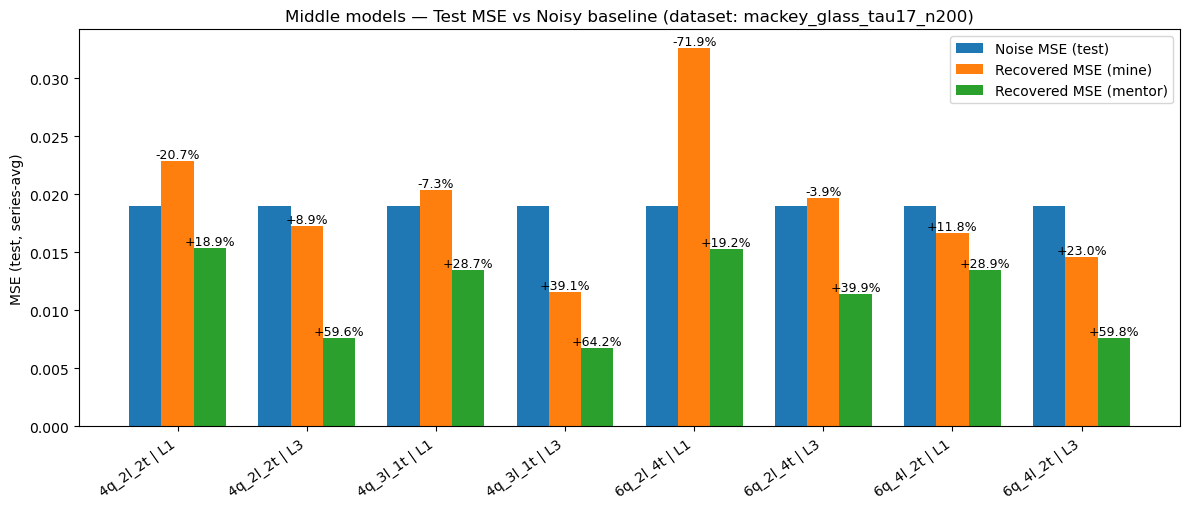

[mackey_glass_tau17_n200] Saved plot → qae_eval_framework/bar_middle_testMSE_mackey_glass_tau17_n200.png


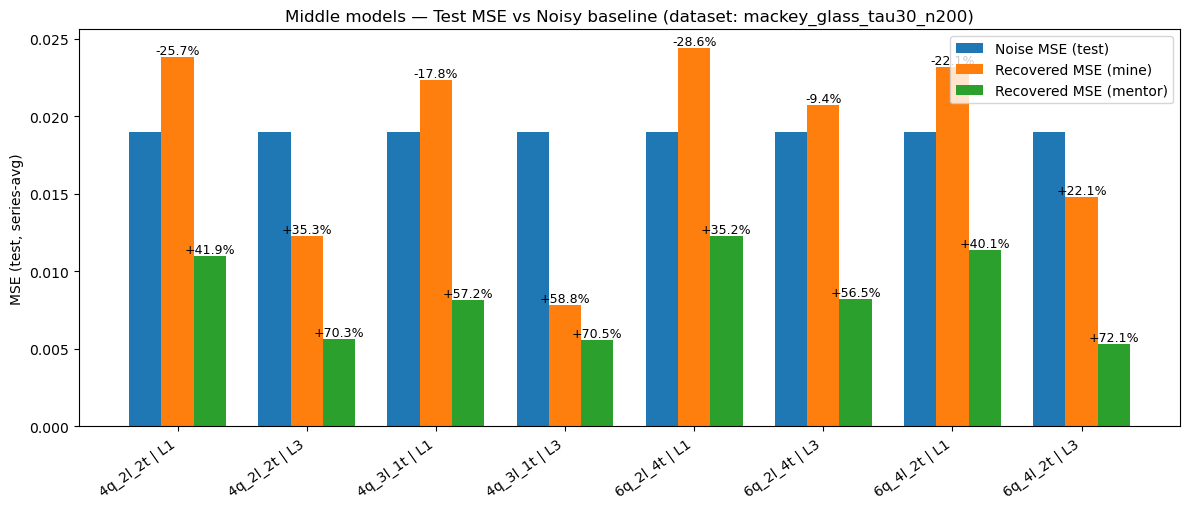

[mackey_glass_tau30_n200] Saved plot → qae_eval_framework/bar_middle_testMSE_mackey_glass_tau30_n200.png


In [ ]:
# ===========================
# Cell 8 — Plots
# ===========================
def _middle_from_df(df):
    mids = []
    for (author, arch_tag, layer), g in df.groupby(["author","arch_tag","layer"], dropna=False):
        g2 = g.sort_values("imp_test_pct")
        mids.append(g2.iloc[len(g2)//2])
    return pd.DataFrame(mids) if len(mids) else pd.DataFrame()

if MAKE_PLOTS:
    for ds in DATASETS:
        if ds in MIDDLE_MODELS and not MIDDLE_MODELS[ds].empty:
            dfm = MIDDLE_MODELS[ds]
        else:
            eval_csv = Path(FRAMEWORK_OUT) / f"eval_all_{ds}.csv"
            if not eval_csv.exists():
                print(f"[{ds}] No eval CSV found; skipping plots.")
                continue
            df_all = pd.read_csv(eval_csv)
            if df_all.empty:
                print(f"[{ds}] eval CSV empty; skipping plots.")
                continue
            dfm = _middle_from_df(df_all)
            if dfm.empty:
                print(f"[{ds}] No middle models could be formed; skipping plots.")
                continue

        mine   = dfm[dfm["author"]=="mine"].copy()
        mentor = dfm[dfm["author"]=="mentor"].copy()

        def make_label(df):
            if df.empty: return df
            df["label"] = df["arch_tag"] + " | L" + df["layer"].astype(int).astype(str)
            return df
        mine = make_label(mine); mentor = make_label(mentor)

        if mentor.empty and not mine.empty:
            labels = list(mine["label"])
            x = np.arange(len(labels))
            width = 0.35

            fig, ax = plt.subplots(figsize=(11.5, 5.2))
            ax.bar(x - width/2, mine["mse_test_noise"].values, width, label="Noise MSE (test)")
            ax.bar(x + width/2, mine["mse_test_recovered"].values, width, label="Recovered MSE (mine)")

            for i, (rec, imp) in enumerate(zip(mine["mse_test_recovered"].values, mine["imp_test_pct"].values)):
                if not np.isnan(rec):
                    ax.text(x[i] + width/2, rec, f"{imp:+.1f}%", ha="center", va="bottom", fontsize=9)

            ax.set_xticks(x, labels, rotation=35, ha="right")
            ax.set_ylabel("MSE (test, series-avg)")
            ax.set_title(f"Mine (middle models) — Test MSE vs Noisy baseline (dataset: {ds})")
            ax.legend()
            fig.tight_layout()

            out_png = Path(FRAMEWORK_OUT) / f"bar_middle_testMSE_{ds}_mine_only.png"
            fig.savefig(out_png, dpi=200, bbox_inches="tight")
            plt.show()
            print(f"[{ds}] Saved plot → {out_png}")
            continue

        if not mine.empty and not mentor.empty:
            labels = sorted(set(mine["label"]).union(set(mentor["label"])))
            mine   = mine.set_index("label").reindex(labels)
            mentor = mentor.set_index("label").reindex(labels)

            noise_vals = []
            for lbl in labels:
                n1 = mine.loc[lbl, "mse_test_noise"]   if lbl in mine.index   else np.nan
                n2 = mentor.loc[lbl, "mse_test_noise"] if lbl in mentor.index else np.nan
                noise_vals.append(np.nanmean([n1, n2]))
            noise_vals = np.asarray(noise_vals)

            x = np.arange(len(labels))
            width = 0.25

            fig, ax = plt.subplots(figsize=(12.0, 5.2))
            ax.bar(x - width, noise_vals, width, label="Noise MSE (test)")
            ax.bar(x,          mine["mse_test_recovered"].values,   width, label="Recovered MSE (mine)")
            ax.bar(x + width,  mentor["mse_test_recovered"].values, width, label="Recovered MSE (mentor)")
            ax.set_xticks(x, labels, rotation=35, ha="right")
            ax.set_ylabel("MSE (test, series-avg)")
            ax.set_title(f"Middle models — Test MSE vs Noisy baseline (dataset: {ds})")
            ax.legend()
            fig.tight_layout()

            # annotate % improvement for both authors
            for i, (rec, imp) in enumerate(zip(mine["mse_test_recovered"].values, mine["imp_test_pct"].values)):
                if not np.isnan(rec):
                    ax.text(x[i], rec, f"{imp:+.1f}%", ha="center", va="bottom", fontsize=9)
            for i, (rec, imp) in enumerate(zip(mentor["mse_test_recovered"].values, mentor["imp_test_pct"].values)):
                if not np.isnan(rec):
                    ax.text(x[i] + width, rec, f"{imp:+.1f}%", ha="center", va="bottom", fontsize=9)

            out_png = Path(FRAMEWORK_OUT) / f"bar_middle_testMSE_{ds}.png"
            fig.savefig(out_png, dpi=200, bbox_inches="tight")
            plt.show()
            print(f"[{ds}] Saved plot → {out_png}")
            continue

        print(f"[{ds}] No mine or mentor middle models to plot.")